In [1]:
import hierarchical

In [2]:
import numpy as np
import daisy

from funlib.evaluate import rand_voi

In [3]:
import matplotlib.pyplot as plt
from skimage import color
from matplotlib.widgets import Slider
from skimage.measure import label
from funlib.segment.arrays import relabel

%matplotlib notebook

In [4]:
def quick_run(
    raw_file,
    raw_dataset,
    pred_file,
    pred_dataset,
    roi,
    downsampling,
    denoising,
    normalize_preds,
    background_mask,
    min_seed_distance,
    merge_function):

    # run post
    segs, frags, proc_pred = hierarchical.post(
        pred_file,
        pred_dataset,
        roi,
        downsampling,
        denoising,
        normalize_preds,
        background_mask,
        min_seed_distance,
        merge_function,
        write=False)
    
    thresholds = sorted(list(segs.keys())) # get merge thresholds
    print(thresholds)
    init_thresh = thresholds[int(len(thresholds)/2)]
    sections = list(range(len(frags))) # get sections
    init_section = int(len(frags)/2) # middle section
    
    # load unprocessed pred
    pred = daisy.open_ds(pred_file,pred_dataset)

    if roi is not None:
        roi = daisy.Roi(pred.roi.offset+daisy.Coordinate(roi[0]),roi[1])
    else:
        roi = pred.roi
            
    # prepare preds for vis
    proc_pred = np.moveaxis(proc_pred[:3,:],0,-1)
    
    #load raw, labels
    raw = daisy.open_ds(raw_file, raw_dataset).to_ndarray(roi)#roi
    
    # setup figure, labels colors
    fcolors = np.random.random((len(np.unique(frags)), 3)) # set fragments colors
    frags = color.label2rgb(frags,colors=fcolors)
    
    fig, axes = plt.subplots(2,2,figsize=(10,10),sharex=False,sharey=False,squeeze=False)

    # horizontal slider to control the merge threshold.
    axthresh = fig.add_axes([0.25, 0.0, 0.65, 0.03])
    thresh_slider = Slider(
        ax=axthresh,
        label='Merge Threshold',
        valmin=min(thresholds),
        valmax=max(thresholds),
        valinit=init_thresh,
        valstep=thresholds)
    
    # vertical slider for section number
    axsection = fig.add_axes([0.0, 0.175, 0.0225, 0.63])
    section_slider = Slider(
        ax=axsection,
        label='Section',
        valmin=sections[0],
        valmax=sections[-1],
        valinit=init_section,
        valstep=sections,
        orientation="vertical")
    
    # plot
    axes[0][0].title.set_text(raw_dataset)
    raw_vis1 = axes[0][0].imshow(raw[init_section], cmap='gray')
    
    axes[0][1].title.set_text(f"processed {pred_dataset}")
    proc_pred_vis = axes[0][1].imshow(proc_pred[init_section])
    
    axes[1][0].title.set_text("raw + frags")
    raw_vis2 = axes[1][0].imshow(raw[init_section], cmap='gray')
    frags_vis = axes[1][0].imshow(frags[init_section], alpha=0.325)
    
    axes[1][1].title.set_text("raw + seg")
    raw_vis3 = axes[1][1].imshow(raw[init_section], cmap='gray')

    seg_vis = axes[1][1].imshow(
        color.label2rgb(
            segs[init_thresh][init_section],
            colors=fcolors[:len(np.unique(segs[init_thresh][init_section])),:]),alpha=0.325)
    
    # slider update function
    def update(val):
        
        new_seg = segs[thresh_slider.val][section_slider.val]
        new_raw = raw[section_slider.val]
        new_frags = frags[section_slider.val]
        new_proc_pred = proc_pred[section_slider.val]

        raw_vis1.set_data(new_raw)
        raw_vis2.set_data(new_raw)
        proc_pred_vis.set_data(new_proc_pred)
        raw_vis3.set_data(new_raw)
        frags_vis.set_data(new_frags)
        seg_vis.set_data(
            color.label2rgb(
                new_seg,
                colors = fcolors[:len(np.unique(new_seg)),:]
            ))  
        
        fig.canvas.draw_idle()

    section_slider.on_changed(update);
    thresh_slider.on_changed(update);
    
    plt.tight_layout()

In [5]:
def evaluate(
    seg,
    labels,
    mask=None,
    thresh=None):
    
    #ensure same shape
    if mask is not None:
        if seg.shape != mask.shape:
            l_z,l_y,l_x = mask.shape[-3:]
            s_z,s_y,s_x = seg.shape[-3:]
            c_z,c_y,c_x = (min(l_z,s_z),min(l_y,s_y),min(l_x,s_x))

            seg = seg[:c_z,:c_y,:c_x] * mask[:c_z,:c_y,:c_x]

        else:
            seg = seg * mask

    if seg.shape != labels.shape:
        l_z,l_y,l_x = labels.shape[-3:]
        s_z,s_y,s_x = seg.shape[-3:]
        c_z,c_y,c_x = (min(l_z,s_z),min(l_y,s_y),min(l_x,s_x))

        labels = labels[:c_z,:c_y,:c_x]
        seg = seg[:c_z,:c_y,:c_x]

    #eval
    metrics = rand_voi(
        labels,
        seg,
        return_cluster_scores=False)

    metrics['merge_threshold'] = thresh
    metrics['voi_sum'] = metrics['voi_split']+metrics['voi_merge']
    metrics['nvi_sum'] = metrics['nvi_split']+metrics['nvi_merge']

    for k in {'voi_split_i', 'voi_merge_j'}:
        del metrics[k]
        
    return metrics, seg

In [6]:
def run(
    raw_file,
    raw_dataset,
    labels_dataset,
    labels_mask,
    pred_file,
    pred_dataset,
    roi,
    downsampling,
    denoising,
    normalize_preds,
    background_mask,
    min_seed_distance,
    merge_function):
    
    # run post
    segs, frags, proc_pred = hierarchical.post(
        pred_file,
        pred_dataset,
        roi,
        downsampling,
        denoising,
        normalize_preds,
        background_mask,
        min_seed_distance,
        merge_function,
        write=False)
    
    thresholds = sorted(list(segs.keys())) # get merge thresholds
    print(thresholds)
    init_thresh = thresholds[int(len(thresholds)/2)]
    sections = list(range(len(frags))) # get sections
    init_section = int(len(frags)/2) # middle section
    
    # load unprocessed pred
    pred = daisy.open_ds(pred_file,pred_dataset)

    if roi is not None:
        roi = daisy.Roi(pred.roi.offset+daisy.Coordinate(roi[0]),roi[1])
    else:
        roi = pred.roi
            
    # prepare preds for vis
    pred = pred.to_ndarray(roi)
    pred = (pred/255.0).astype(np.float32) if pred.dtype==np.uint8 else pred
    pred = np.expand_dims(pred,1) if init_section==0 else pred
    pred = np.stack([np.ones_like(pred[0]),pred[0],pred[1]]) if pred.shape[0]==2 else pred
    
    pred = np.moveaxis(pred[:3,:],0,-1)
    proc_pred = np.moveaxis(proc_pred[:3,:],0,-1)
    
    #load raw, labels
    raw = daisy.open_ds(raw_file, raw_dataset).to_ndarray(roi)#roi
    labels = daisy.open_ds(raw_file,labels_dataset)
    labels = labels.to_ndarray(roi,fill_value=0)
    
    #eval segs
    results = {}
    
    if labels_mask:
        mask = daisy.open_ds(raw_file,labels_mask)
        mask = mask.to_ndarray(roi,fill_value=0)
    else:
        mask = None

    for thresh, seg in segs.items():

        results[thresh],seg = evaluate(seg,labels,mask,thresh)
        
        #update segs with mask
        segs[thresh] = seg

    #eval frags
    frags_metrics, frags = evaluate(frags,labels,mask)
        
    # setup figure, labels colors
    fcolors = np.random.random((len(np.unique(frags)), 3)) # set fragments colors
    frags = color.label2rgb(frags,colors=fcolors)
    labels = color.label2rgb(labels,colors=np.random.random((len(np.unique(labels)), 3)))
    
    fig, axes = plt.subplots(2,3,figsize=(10,6.666),sharex=False,sharey=False,squeeze=False)

    # horizontal slider to control the merge threshold.
    axthresh = fig.add_axes([0.25, 0.025, 0.65, 0.03])
    thresh_slider = Slider(
        ax=axthresh,
        label='Merge Threshold',
        valmin=min(thresholds),
        valmax=max(thresholds),
        valinit=init_thresh,
        valstep=thresholds)
    
    # vertical slider for section number
    axsection = fig.add_axes([0.035, 0.175, 0.0225, 0.63])
    section_slider = Slider(
        ax=axsection,
        label='Section',
        valmin=sections[0],
        valmax=sections[-1],
        valinit=init_section,
        valstep=sections,
        orientation="vertical")
    
    # plot
    axes[0][0].title.set_text(raw_dataset)
    raw_vis1 = axes[0][0].imshow(raw[init_section], cmap='gray')

    axes[0][1].title.set_text(f"raw + {labels_dataset}")
    raw_vis2 = axes[0][1].imshow(raw[init_section], cmap='gray')
    labels_vis1 = axes[0][1].imshow(labels[init_section], alpha=0.5)
    
    axes[0][2].title.set_text(f"predicted {pred_dataset}")
    pred_vis1 = axes[0][2].imshow(pred[init_section])
    
    axes[1][0].title.set_text(f"processed {pred_dataset}")
    proc_pred_vis1 = axes[1][0].imshow(proc_pred[init_section])
    
    axes[1][1].title.set_text("raw + frags")
    raw_vis3 = axes[1][1].imshow(raw[init_section], cmap='gray')
    frags_vis1 = axes[1][1].imshow(frags[init_section], alpha=0.5)
    
    axes[1][2].title.set_text("raw + seg")
    raw_vis4 = axes[1][2].imshow(raw[init_section], cmap='gray')

    seg_vis1 = axes[1][2].imshow(
        color.label2rgb(
            segs[init_thresh][init_section],
            colors=fcolors[:len(np.unique(segs[init_thresh][init_section])),:]),alpha=0.5)
    
    # slider update function
    def update(val):
        
        new_seg = segs[thresh_slider.val][section_slider.val]
        new_raw = raw[section_slider.val]
        new_frags = frags[section_slider.val]
        new_labels = labels[section_slider.val]
        new_proc_pred = proc_pred[section_slider.val]
        new_pred = pred[section_slider.val]
        
        raw_vis1.set_data(new_raw)
        raw_vis2.set_data(new_raw)
        labels_vis1.set_data(new_labels)
        pred_vis1.set_data(new_pred)
        proc_pred_vis1.set_data(new_proc_pred)
        raw_vis3.set_data(new_raw)
        frags_vis1.set_data(new_frags)
        raw_vis4.set_data(new_raw)
        seg_vis1.set_data(
            color.label2rgb(
                new_seg,
                colors = fcolors[:len(np.unique(new_seg)),:]
            ))  
        
        fig.canvas.draw_idle()

    section_slider.on_changed(update);
    thresh_slider.on_changed(update);
    
    #print best result
    best_thresh = sorted([(results[thresh]['nvi_sum'],thresh) for thresh in thresholds])
    best_thresh = best_thresh[0][1]
    print(results[best_thresh])

In [44]:
raw_file = '/scratch/04101/vvenu/sparsity/epi/data/crop_N_511_final_crop_ds2.zarr'
pred_file = '/scratch/04101/vvenu/sparsity/epi/affs_nets/affs/A/2d_crop_N_511_final_crop_ds2.zarr'
pred_dataset = 'mtlsd/obj_050/rep_2/3d_affs_10000_from_stacked_affs_10000'
labels_dataset = "labels"
raw_dataset = "raw"
labels_mask = "unlabelled"

# raw_file = "/scratch/04101/vvenu/xray-challenge-entry/data/xpress-challenge.zarr"
# raw_dataset = "volumes/validation_raw"
# pred_file = "/scratch/04101/vvenu/xray-challenge-entry/setups/vijay_baselines/NoiseAug_mtlsd/xpress-challenge.zarr"
# #pred_file = "/scratch/04101/vvenu/xray-challenge-entry/setups/vijay_baselines/Lsd_to_affs/arlo_mid/xpress-challenge.zarr"
# #pred_dataset = "lsd/3d_affs_20000_from_lsds_2000"
# pred_dataset = "affs_2000"

roi = None
roi = [[2350, 10800, 7050], [4700, 37500, 37500/2]] # epi
#roi = ((1500, 5160, 5488),(500, 1600, 1600))
#roi = [[14*8,140*8,140*8],[56,1600,1600]] #fib25
#roi = [[560,197*8,197*8],[280,1600,1600]] #cremi
#roi = [[4*235,360*75,360*75],[235*7,200*75,200*75]]
#roi = ((6600,3300,3300),(3300,9900,9900))

downsampling = None#["rescale",2]
denoising = None#['bilateral', 0.05, 0.2]
normalize_preds = False#True

background_mask = False
min_seed_distance = 10

merge_function = 'mean'

Re-using already compiled waterz version
[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98]


<IPython.core.display.Javascript object>


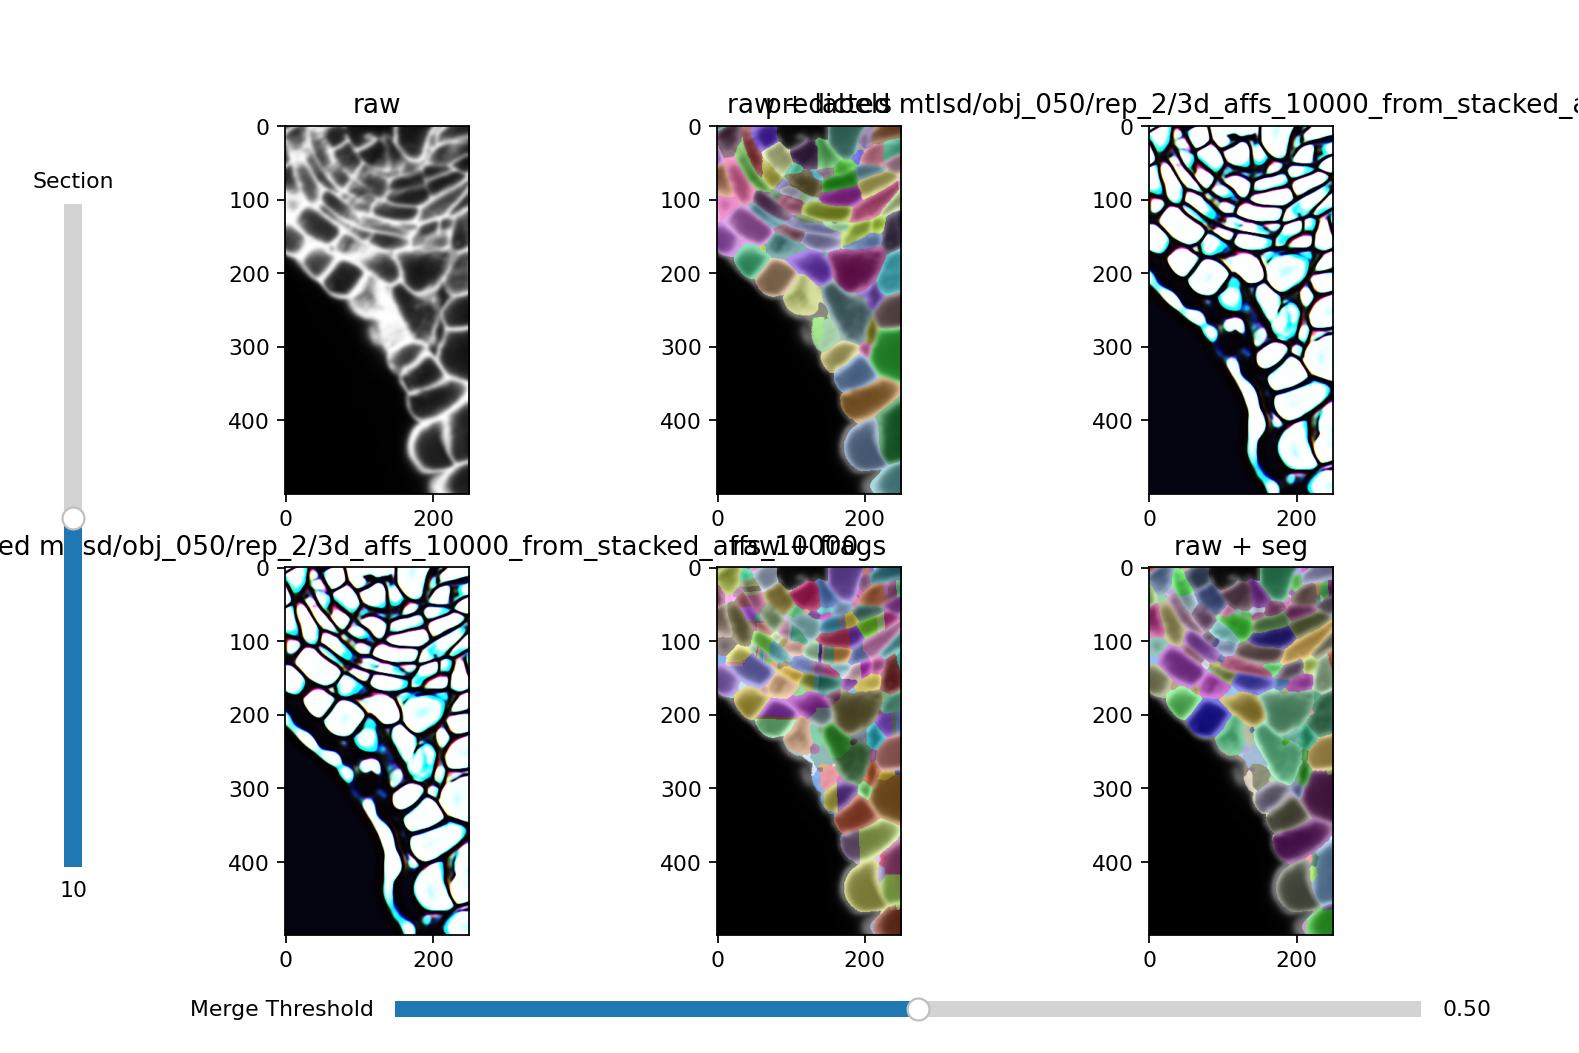

{'rand_split': 0.7898523660855353, 'rand_merge': 0.7988711751690497, 'voi_split': 1.0174986106991089, 'voi_merge': 0.767583345353315, 'nvi_split': 0.13686824176774715, 'nvi_merge': 0.10325103325352941, 'nid': 0.1526271530195613, 'merge_threshold': 0.78, 'voi_sum': 1.7850819560524238, 'nvi_sum': 0.24011927502127656}


In [45]:
run(
    raw_file,
    raw_dataset,
    labels_dataset,
    labels_mask,
    pred_file,
    pred_dataset,
    roi,
    downsampling,
    denoising,
    normalize_preds,
    background_mask,
    min_seed_distance,
    merge_function)

In [46]:
# quick_run(
#     raw_file,
#     raw_dataset,
#     pred_file,
#     pred_dataset,
#     roi,
#     downsampling,
#     denoising,
#     normalize_preds,
#     background_mask,
#     min_seed_distance,
#     merge_function)